I am currently super excited about t-distributed stochastic neighbor embedding (t-SNE) for visualizing high dimensional data. Especially when training neural networks it helps a lot with understanding what's going on inside the network. In this notebook I'll use t-SNE to train and visualize a neural network that predicts housing prices. Let's start with visualizing the raw data. I prepare the data (in a very lazy way) by first checking the data type in the first non-header row. I found that there a a lot of columns with strings and integers and a few with float values. For now I work only with the integer and string values. I lazily assume that all all integer values describe ordinal or interval data and all string values are categorical. To deal with the categorical data I encode it in one-hot representation.
After data preparation I get a 2D embedding and plot the result in a scatter plot. Color encodes the houses log values from blue/low to red/high.

sample_submission.csv
test.csv
train.csv

embedding int values...
embedding string values...
embedding int and string values...


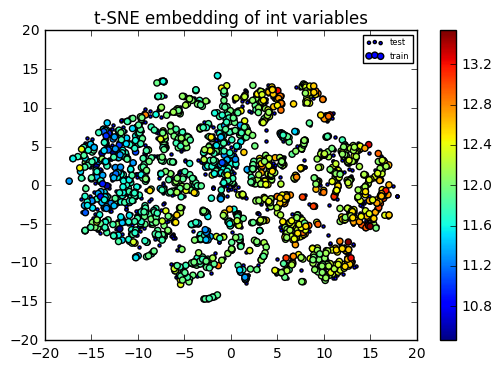

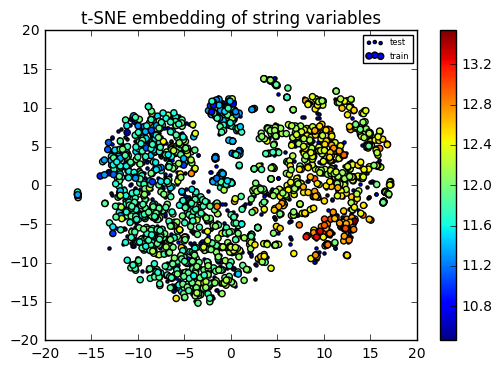

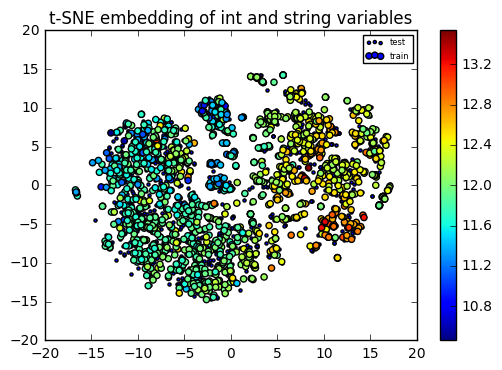

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import manifold
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

X1 = train.values[:,1:-1]
X2 = test.values[:,1:]

X = np.concatenate((X1,X2),axis=0)
y1 = train.values[:,-1]
y1 = np.asarray([np.log(y) for y in y1])
#-----------------------------------------
# Preprocessing
#-----------------------------------------
# 1: separate different variable types
cat_idx = []
float_idx = []
int_idx = []
for c in range(X1.shape[1]):
    if type(X1[0,c]).__name__ == 'str':
        cat_idx.append(c)
    if type(X1[0,c]).__name__ == 'float' and X1[1,c]==X1[1,c]:
        float_idx.append(c)
    if type(X1[0,c]).__name__ == 'int':
        int_idx.append(c)
# 2: encode string values into numbers
for c in cat_idx:
    uniques = list(set(X[:,c]))
    tmp_dict = dict(zip(uniques,range(len(uniques))))
    n_enc = np.array([tmp_dict[s] for s in X[:,c]])
    X[:,c] = n_enc
        
# 3: what does an embedding of all int values look like?
print('embedding int values...')
plt.figure(1)
X_int = X[:,np.array(int_idx)]
X_int = np.float64(X_int)
# replace nan
X_int[X_int!=X_int] = 0
X_int-=np.min(X_int,axis=0)
X_int/=(.001+np.max(X_int,axis=0))
tsne = manifold.TSNE(n_components=2,init='pca')
Y_int = tsne.fit_transform(X_int)
#y1-=np.nanmin(y1)
#y1/=np.nanmax(y1)
plt.scatter(Y_int[len(X1):,0],Y_int[len(X1):,1],marker='.',label='test')
sp = plt.scatter(Y_int[:len(X1),0],Y_int[:len(X1),1],c=y1,label='train')
plt.legend(prop={'size':6})
plt.colorbar(sp)
plt.title('t-SNE embedding of int variables')
plt.savefig('t-SNE_int.png')

# 4: what does an embedding of all string values look like?
print('embedding string values...')
plt.figure(2)
X_str = X[:,np.array(cat_idx)]
# replace nan
X_str[X_str!=X_str] = 0

def onehot(x):
    nx=np.zeros((len(x),max(x)+1))
    for k in range(len(x)):
        nx[k,x[k]] = 1
    return nx

X_tmp = []
for c in range(X_str.shape[1]):
    X_tmp.extend(onehot(X_str[:,c]).T)
X_str = np.asarray(X_tmp).T
tsne = manifold.TSNE(n_components=2,init='pca')
Y_str = tsne.fit_transform(X_str)
#y1-=np.nanmin(y1)
#y1/=np.nanmax(y1)
plt.scatter(Y_str[len(X1):,0],Y_str[len(X1):,1],marker='.',label='test')
sp = plt.scatter(Y_str[:len(X1),0],Y_str[:len(X1),1],c=y1,label='train')
plt.legend(prop={'size':6})
plt.colorbar(sp)
plt.title('t-SNE embedding of string variables')
plt.savefig('t-SNE_string.png')

# 4: what does an embedding of all int and string values look like?
print('embedding int and string values...')
plt.figure(3)
X_strint = np.concatenate((X_int,X_str),axis=1)
tsne = manifold.TSNE(n_components=2,init='pca')
Y_strint = tsne.fit_transform(X_strint)
plt.scatter(Y_strint[len(X1):,0],Y_strint[len(X1):,1],marker='.',label='test')
sp = plt.scatter(Y_strint[:len(X1),0],Y_strint[:len(X1),1],c=y1,label='train')
plt.legend(prop={'size':6})
plt.colorbar(sp)
plt.title('t-SNE embedding of int and string variables')
plt.savefig('t-SNE_intstring.png')

# center data at 0 scaled from -0.5 to +0.5 for neural networks
# -> start within the linear region of tanh activation function
X_strint-=.5
X_strint_train = X_strint[:len(X1),:]
X_strint_test = X_strint[len(X1):,:]

Now let's see how a neural network changes this result.

Using TensorFlow backend.


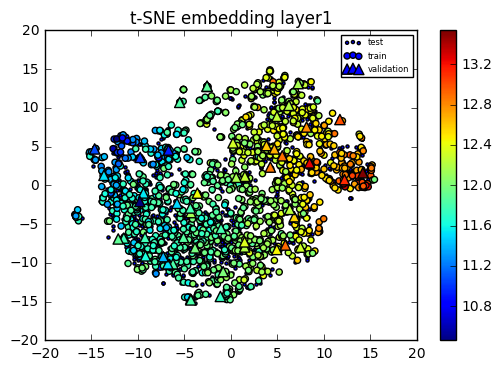

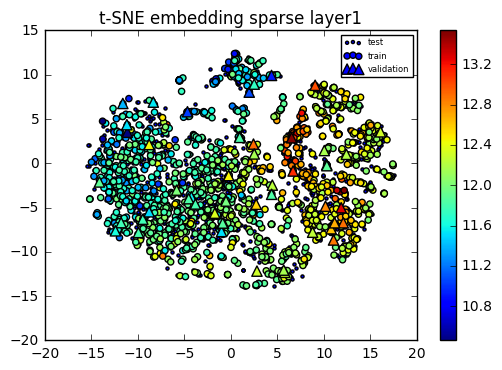

In [2]:
from keras.models import Model
from keras.layers import Input,Dense,Dropout,BatchNormalization
from keras import regularizers

#--------------------------------------
# Neural Network
#--------------------------------------
inp = Input(shape=(X_strint.shape[1],))
D1 = Dropout(.1)(inp)
L1_normal = Dense(64, init='uniform', activation='tanh')(D1)
L1_sparse = Dense(1024, init='uniform', activation='tanh',activity_regularizer=regularizers.activity_l1(.001))(D1)
L2_normal = Dense(1, init='uniform', activation='tanh')(L1_normal)
L2_sparse = Dense(1, init='uniform', activation='tanh')(L1_sparse)
# models that are trained to predict prices
NN1 = Model(inp,L2_normal)
NN2 = Model(inp,L2_sparse)
# models for reading out activations in hidden layers
enc1 = Model(inp,L1_normal)
enc2 = Model(inp,L1_sparse)
# compile models
NN1.compile(loss='mse', optimizer='adam', metrics=['mae'])
NN2.compile(loss='mse', optimizer='adam', metrics=['mae'])
enc1.compile(loss='mse', optimizer='adam', metrics=['mae'])
enc2.compile(loss='mse', optimizer='adam', metrics=['mae'])
# train
min_y1 = np.min(y1)
max_y1 = np.max(y1)
scaled_y1 = y1-min_y1
scaled_y1/=max_y1
scaled_y1-=.5
NN1.fit(X_strint_train[:-50,:], scaled_y1[:-50], nb_epoch=15, batch_size=3, shuffle=True,verbose=False)
NN2.fit(X_strint_train[:-50,:], scaled_y1[:-50], nb_epoch=15, batch_size=3, shuffle=True,verbose=False)

# get hidden layer activations
P1 = enc1.predict(X_strint)
P2 = enc2.predict(X_strint)
# get 2d embeddings
tsne = manifold.TSNE(n_components=2,init='pca')
P1_tsne = tsne.fit_transform(P1)
P2_tsne = tsne.fit_transform(P2)

P1_tsne_train = P1_tsne[:len(X1),:]
P2_tsne_train = P2_tsne[:len(X1),:]
P1_tsne_test = P1_tsne[len(X1):,:]
P2_tsne_test = P2_tsne[len(X1):,:]

plt.figure(1)
plt.scatter(P1_tsne_test[:,0],P1_tsne_test[:,1],marker='.',label='test')
sp1 = plt.scatter(P1_tsne_train[:-50,0],P1_tsne_train[:-50,1],c=y1[:-50],label='train')
plt.scatter(P1_tsne_train[-50:,0],P1_tsne_train[-50:,1],marker='^',s=55, c=y1[-50:],label='validation')
plt.colorbar(sp1)
plt.legend(prop={'size':6})
plt.title('t-SNE embedding layer1')
plt.savefig('t-SNE_layer1.png')

plt.figure(2)
plt.scatter(P2_tsne_test[:,0],P2_tsne_test[:,1],marker='.',label='test')
sp2 = plt.scatter(P2_tsne_train[:-50,0],P2_tsne_train[:-50,1],c=y1[:-50],label='train')
plt.scatter(P2_tsne_train[-50:,0],P2_tsne_train[-50:,1],marker='^',s=55, c=y1[-50:],label='validation')
plt.colorbar(sp2)
plt.legend(prop={'size':6})
plt.title('t-SNE embedding sparse layer1')
plt.savefig('t-SNE_layer1sparse.png')

I trained two different neural networks, each with one hidden layer: 
Network 1 has 64 units in its hidden layer, i.e. the data was compressed to 64 dimensions.
Network 2 has a sparse hidden layer with 1024 units.

While Network 1 did a better job in terms of data representation in the shown examples, this does not seem to be the general case as I did observe opposite results in different runs.

However what I could observe over multiple runs is that the hidden layers of both networks rearrange the data so that the distance between data points better represents their difference in value.
Let's see what happens if we add more layers to the network:

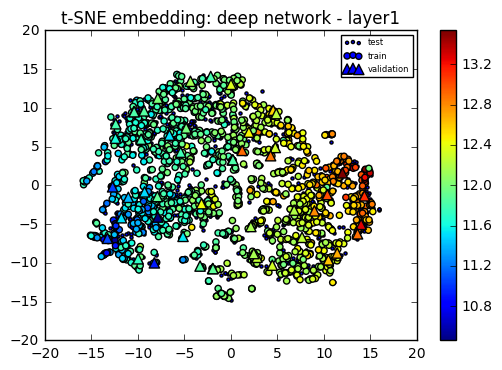

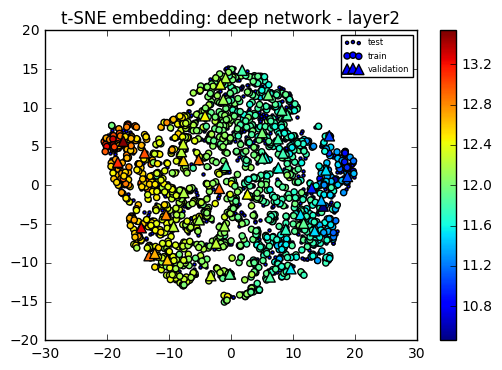

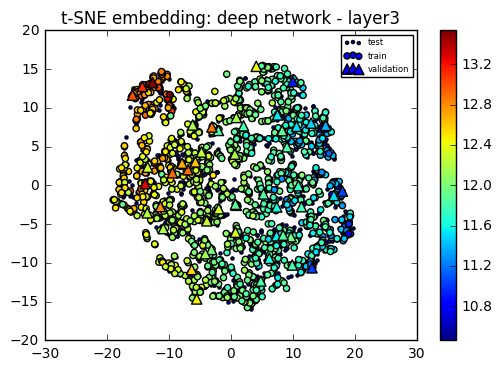

In [3]:
#--------------------------------------
# Deep Neural Network
#--------------------------------------
inp = Input(shape=(X_strint.shape[1],))
D1 = Dropout(.1)(inp)
L1 = Dense(64, init='uniform', activation='tanh')(D1)
N1 = BatchNormalization()(L1)
D2 = Dropout(.2)(N1)
L2 = Dense(64, init='uniform', activation='tanh')(D2)
N2 = BatchNormalization()(L2)
D3 = Dropout(.2)(N2)
L3 = Dense(36, init='uniform', activation='tanh')(D3)
N3 = BatchNormalization()(L3)
D4 = Dropout(.2)(N3)
L4 = Dense(1, init='uniform', activation='tanh')(D4)
# model that is trained to predict prices
model1 = Model(inp,L4)
# models for reading out activations in hidden layers
enc_l1 = Model(inp,L1)
enc_l2 = Model(inp,L2)
enc_l3 = Model(inp,L3)
# compile models
model1.compile(loss='mse', optimizer='adam', metrics=['mae'])
enc_l1.compile(loss='mse', optimizer='adam', metrics=['mae'])
enc_l2.compile(loss='mse', optimizer='adam', metrics=['mae'])
enc_l3.compile(loss='mse', optimizer='adam', metrics=['mae'])
# train
min_y1 = np.min(y1)
max_y1 = np.max(y1)
scaled_y1 = y1-min_y1
scaled_y1/=max_y1
model1.fit(X_strint_train[:-50,:], scaled_y1[:-50], nb_epoch=55, batch_size=3, shuffle=True,verbose=False)
# get hidden layer activations
P1 = enc_l1.predict(X_strint)
P2 = enc_l2.predict(X_strint)
P3 = enc_l3.predict(X_strint)
# get 2d embeddings
tsne = manifold.TSNE(n_components=2,init='pca')
P1_tsne = tsne.fit_transform(P1)
P2_tsne = tsne.fit_transform(P2)
P3_tsne = tsne.fit_transform(P3)

P1_tsne_train = P1_tsne[:len(X1),:]
P2_tsne_train = P2_tsne[:len(X1),:]
P3_tsne_train = P3_tsne[:len(X1),:]
P1_tsne_test = P1_tsne[len(X1):,:]
P2_tsne_test = P2_tsne[len(X1):,:]
P3_tsne_test = P3_tsne[len(X1):,:]

plt.figure(3)
plt.scatter(P1_tsne_test[:,0],P1_tsne_test[:,1],marker='.',label='test')
sp1 = plt.scatter(P1_tsne_train[:-50,0],P1_tsne_train[:-50,1],c=y1[:-50],label='train')
plt.scatter(P1_tsne_train[-50:,0],P1_tsne_train[-50:,1],marker='^',s=55, c=y1[-50:],label='validation')
plt.colorbar(sp1)
plt.legend(prop={'size':6})
plt.title('t-SNE embedding: deep network - layer1')
plt.savefig('t-SNE_deep_layer1.png')

plt.figure(4)
plt.scatter(P2_tsne_test[:,0],P2_tsne_test[:,1],marker='.',label='test')
sp1 = plt.scatter(P2_tsne_train[:-50,0],P2_tsne_train[:-50,1],c=y1[:-50],label='train')
plt.scatter(P2_tsne_train[-50:,0],P2_tsne_train[-50:,1],marker='^',s=55, c=y1[-50:],label='validation')
plt.colorbar(sp1)
plt.legend(prop={'size':6})
plt.title('t-SNE embedding: deep network - layer2')
plt.savefig('t-SNE_deep_layer2.png')

plt.figure(5)
plt.scatter(P3_tsne_test[:,0],P3_tsne_test[:,1],marker='.',label='test')
sp1 = plt.scatter(P3_tsne_train[:-50,0],P3_tsne_train[:-50,1],c=y1[:-50],label='train')
plt.scatter(P3_tsne_train[-50:,0],P3_tsne_train[-50:,1],marker='^',s=55, c=y1[-50:],label='validation')
plt.colorbar(sp1)
plt.legend(prop={'size':6})
plt.title('t-SNE embedding: deep network - layer3')
plt.savefig('t-SNE_deep_layer3.png')